# Make Combined Dataframe and draw results in Video 

In [33]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import os
import random
import sys
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from pathlib import Path
import multiprocessing as mp
import tables
import scipy.io as sio
from scipy.ndimage.measurements import center_of_mass
from scipy.spatial.distance import euclidean
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import Rectangle #changed

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

from utils.graphic_utils import *
from utils.detectron_utils import *
from utils.dataframe_utils import *


In [34]:
DATASET = 'LUEBECK/'
hpc = False
segmentation = 'panoptic'

DIR = Path(os.path.dirname(os.path.realpath('__file__'))).parent
if (DIR== Path('/beegfs/home/users/t/tim.schroeder/')):
    CODE_DIR = os.path.join(DIR, 'object_rep/project_code/') 
    hpc = True
else: 
    CODE_DIR = DIR

print('CODE_DIR: ', CODE_DIR)
PROJECT_DIR = Path(CODE_DIR).parent
print('PROJECT_DIR: ', PROJECT_DIR)
DATA_DIR = os.path.join(PROJECT_DIR, 'project_data.nosync/')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'project_results.nosync/')
D_DIR = os.path.join(PROJECT_DIR, 'project_results.nosync/','panoptic-seg/')
print('RESULTS_DIR: ', RESULTS_DIR)

ROOT_DIR = os.path.join(CODE_DIR, "detectron2/")
print('ROOT_DIR: ', ROOT_DIR)

sys.path.append(ROOT_DIR)
from demo.predictor import VisualizationDemo
print('HPC:', hpc)

CODE_DIR:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_code
PROJECT_DIR:  /Users/timschroder/Documents/Uni/Bachelorarbeit
RESULTS_DIR:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/
ROOT_DIR:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/detectron2/
HPC: False


In [35]:
def setup_cfg():
    cfg = get_cfg()
    if segmentation == 'panoptic':
        cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
    elif segmentation == 'mrcnn':
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
    if not hpc: 
        cfg.MODEL.DEVICE = 'cpu' #only on local device

    cfg.freeze()
    return cfg

In [36]:
def matchScore(x,y,mask):
    center = center_of_mass(mask)
    distanceFromCenter = euclidean(center,(y,x))
    size = np.count_nonzero(mask)
    maxDist = 1468
    maxSize = 921600
    score = (((1/(maxSize**2))*(size-maxSize)**2) + (1-distanceFromCenter/maxDist))/2
    return score

In [37]:
cfg = setup_cfg() #Define Classifier for Panoptic Segmentation
predictor = DefaultPredictor(cfg)
demo = VisualizationDemo(cfg)
metadata = demo.metadata

In [21]:
GAZE_FOLDER_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/'
gaze_folder_list = [video for video in glob.glob(GAZE_FOLDER_DIR + '/*')]
gaze_folder_list.sort()


VIDEO_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK/'
video_path_list = [video for video in glob.glob(VIDEO_DIR + '/*')]
video_path_list.sort()


detect_path_list = [video for video in glob.glob(RESULTS_DIR + 'detect_video/' + '*.avi')]
detect_path_list.sort()

data_path_list = [video for video in glob.glob(D_DIR + '*_data.npy')]
data_path_list.sort()
data_path_list

info_path_list = [video for video in glob.glob(D_DIR + '*_deepsort.npy')]
info_path_list.sort()


## Make Dataframe how Gaze Allocation correlates with Panoptic Segmentation, Motion & Proto Object

In [32]:
translate_dict = {'UNKNOWN':0, 'FIX':1, 'SACCADE':2, 'SP':3, 'NOISE':4}

radius = 26.7 # 1° of visual angle is equvialent to radius of 13.35 pixel , 2° = 26.7 pixel ...
fps=30

fourcc = cv2.VideoWriter_fourcc(*'DIVX')

videos_run = [17]#[s for s in range(16,17)]

num_sal_objects = 5
markersize = 50
maxframes = 600
nframes = 595

for v in tqdm(videos_run):#tqdm(range(videos_run), desc="videos"):
    for radius in [13.35]: # [13.35,26.7]:
        videoloc = detect_path_list[v] #+1  panoptic Segmented Video
        #vid = imageio.get_reader(videoloc,  'ffmpeg')
        vidlist = []
        

        video_name = os.path.splitext(os.path.basename(videoloc))[0]
        print(video_name)

        molinSaliency_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/molinSaliency/' + video_name + '.mat'
        myData_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/myData/' + video_name + '.mat'
        waltherData_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/waltherData/' + video_name + '.mat'

        molinSaliency_raw = sio.loadmat(molinSaliency_path)
        myData_raw = sio.loadmat(myData_path)
        waltherData_raw = sio.loadmat(waltherData_path)

        molinSaliency = np.asarray(molinSaliency_raw['molin_sal_maps'])     #.shape = (450, 800, 596)
        myProto = np.asarray(myData_raw['S'])           #.shape = (28, 50, 596)
        waltherProto = np.asarray(waltherData_raw['S']) #.shape = (28, 50, 596)
        """
        motion_proto_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/mySaliency/' + video_name + '.mat'
        motion_proto = sio.loadmat(motion_proto_path)
        motion_proto_maps = np.asarray(motion_proto['S'])
        """
        gaze_dir = gaze_folder_list[v] #+1
        gaze_path_list = [video for video in glob.glob(gaze_dir + '/*')]
        gaze_path_list.sort()
        print(gaze_dir)
        print(data_path_list[v])
        print(info_path_list[v-1])

        # load panoptic segmentation results
        panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
        segments_info = np.load(info_path_list[v-1],allow_pickle=True) ## change back later!! to v
        
        subjects_run = [s for s in range(len(gaze_path_list))]
        for s in tqdm(subjects_run, desc="subjects"):
            subject_name = os.path.splitext(os.path.basename(gaze_path_list[s]))[0][0:3]
            num_frames = min(maxframes,nframes, len(panoptic_seg))
            if not os.path.isdir(RESULTS_DIR +'df2/' + video_name):
                os.mkdir(RESULTS_DIR +'df2/' + video_name)

            DF_NAME = os.path.join(RESULTS_DIR,'df2/',video_name, video_name + '_' + subject_name + '_' + str(num_frames) + '_r='+str(radius)+'_mostSalient.pkl')
        
            gaze_path = gaze_path_list[s]
            print(gaze_path)
        # video_name = os.path.splitext(path_leaf(gaze_path_list[s]))[0]
            df = load_df(gaze_path)
            
            # go to either the full video or only through a certain number of frames
            df['class_id'] = ''
            df['thing'] = ''
            df['panoptic_score'] = np.nan
            df['motion_proto_id'] = ''
            df['proto_score'] = np.nan
            
            #df['walther_proto_id'] = ''

            
            for f in tqdm(range(num_frames), desc="frames"):
                dtemp = df[(df['time'] >= 1e3*f/fps) & (df['time'] < 1e3*(f+1)/fps)] # assign data to frames
                
                for i in dtemp.index:
                    
                    # PANOPTIC 
                    x_coord = int(dtemp['x'][i])
                    y_coord = int(dtemp['y'][i])
                    track_id = -1
                    panoptic_score = 0
                    panoptic_mask = panoptic_seg[f].numpy()
                    segment_id = panoptic_mask[y_coord,x_coord]
                    isthing = segments_info[f][segment_id-1]['isthing'] #-1 because of indexing
                    category_id = segments_info[f][segment_id-1]['category_id']
                    if 'track_id' in segments_info[f][segment_id-1]:
                        track_id = segments_info[f][segment_id-1]['track_id']

                    if isthing: #if point of interest is thing, label with thing_classes_label
                        label = metadata.thing_classes[category_id]
                        panoptic_score = matchScore(x_coord,y_coord,(panoptic_mask == segment_id))


                    else: #else check if stuff area of size (2*radius)^2 contains any other stuff or objects
                        y,x = np.ogrid[-y_coord:720-y_coord, -x_coord:1280-x_coord]
                        r=radius
                        mask = x*x + y*y <= r*r
                        area_of_interest = panoptic_seg[f].numpy()[mask] #circular mask to simulate foveate vision
                        aoi_segment_ids = np.unique(area_of_interest)
                        if len(aoi_segment_ids)>1: #if there are any other stuff or objects, check if the next most dominant one is stuff or thing
                            if segments_info[f][aoi_segment_ids[1]-1]['isthing']: # if the next most dominant one is thing, obtain with thing_class_label
                                category_id = segments_info[f][aoi_segment_ids[1]-1]['category_id']
                                label = metadata.thing_classes[category_id]
                                isthing = True
                                panoptic_score = matchScore(x_coord,y_coord,(panoptic_mask == aoi_segment_ids[1]))
                            else: # obtain with stuff_class_label
                                label = metadata.stuff_classes[category_id]
                        else:
                            label = metadata.stuff_classes[category_id]



                    df.at[i,'class_id'] = label
                    df.at[i, 'thing'] = isthing
                    df.at[i, 'track_id'] = track_id
                    df.at[i, 'panoptic_score'] = panoptic_score
                    
                    dtemp.at[i, 'class_id'] = label
                    dtemp.at[i, 'thing'] = isthing
                    dtemp.at[i, 'track_id'] = track_id
                    dtemp.at[i, 'panoptic_score'] = panoptic_score

                    # MOTION PROTO OBJECT
                    proto_score = 0
                    motion_proto_id = 0
                    for n in range(0,5):
                        resized = cv2.resize(myProto[f,:,:,n], (1280,720), interpolation = cv2.INTER_AREA)
                        blur = cv2.blur(resized,(20,20))
                        if blur[y_coord][x_coord] != 0:
                            motion_proto_id = n+1
                            proto_score = matchScore(x_coord,y_coord,blur)
                            break

                        area_of_interest = blur[mask] #same mask as for panoptic
                        aoi_segment_ids = np.unique(area_of_interest)
                        if len(aoi_segment_ids)>1:
                            motion_proto_id = n+1
                            proto_score = matchScore(x_coord,y_coord,blur)
                            break

                    # WALTHER PROTO OBJECT
            
                    walther_proto_id = 0
                    for n in range(0,5):
                        resized = cv2.resize(waltherProto[f,:,:,n], (1280,720), interpolation = cv2.INTER_AREA)
                        blur = cv2.blur(resized,(20,20))
                        if blur[y_coord][x_coord] != 0:
                            walther_proto_id = n+1
                           # proto_score = matchScore(x_coord,y_coord,blur)
                            break

                        area_of_interest = blur[mask] #same mask as for panoptic
                        aoi_segment_ids = np.unique(area_of_interest)
                        if len(aoi_segment_ids)>1:
                            walther_proto_id = n+1
                           # proto_score = matchScore(x_coord,y_coord,blur)
                            break
                    
                    # Check most salient objects in panoptic segmentation
                    if 'molin_salient_object' in segments_info[f][segment_id-1]:
                        df.at[i,'molin_salient_object'] = segments_info[f][segment_id-1]['molin_salient_object']
                    else:
                        df.at[i,'molin_salient_object'] = np.nan
                
                    df.at[i,'motion_proto_id'] = motion_proto_id
                    df.at[i,'proto_score'] = proto_score
                    df.at[i,'walther_proto_id'] = walther_proto_id
                    
                    dtemp.at[i, 'motion_proto_id'] = motion_proto_id
                    dtemp.at[i, 'proto_score'] = proto_score
                    dtemp.at[i, 'walther_proto_id'] = walther_proto_id
                    
            df.to_pickle(DF_NAME)   
            print('done!')


street
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/street
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/street_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/street_info_deepsort.npy


/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/street/AAF_street.arff


IndexError: list index out of range

In [29]:
v

16

In [21]:
df = pd.read_pickle(DF_NAME)

In [55]:
df.handlabeller_final.value_counts()

FIX        2682
SP         1301
SACCADE     539
NOISE       419
Name: handlabeller_final, dtype: int64

## Draw both Panoptic Segmentation and Proto Objects in Video

In [14]:
GAZEVID_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/LUEBECK/gaze_video/'
translate_dict = {'UNKNOWN':0, 'FIX':1, 'SACCADE':2, 'SP':3, 'NOISE':4}

radius = 10 

fps=30
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

videos_run = [0]#[s for s in range(3,17)]
subjects_run = [0]#[s for s in range(0,17)]

markersize = 50
maxframes = 600

for v in tqdm(videos_run, desc="videos"):#len(video_path_list)
    videoloc = detect_path_list[v] #video_path_list[v]
    #print('Video: %s' % videoloc)
    vid = imageio.get_reader(videoloc,  'ffmpeg')
    vidlist = []

    video_name = os.path.splitext(os.path.basename(videoloc))[0]
    video_dir = os.path.join(RESULTS_DIR,'final/',video_name)
    if not os.path.isdir(video_dir):
        os.mkdir(video_dir)    #make results directory
    
    df_dir = os.path.join(RESULTS_DIR,'df/',video_name)

    gaze_dir = gaze_folder_list[v]
    gaze_path_list = [video for video in glob.glob(gaze_dir + '/*')]
    gaze_path_list.sort()

    for image in vid.iter_data():
        vidlist.append(np.array(image))
        
    
    for s in tqdm(subjects_run, desc="subjects"):
        subject_name = os.path.splitext(os.path.basename(gaze_path_list[s]))[0][0:3]

        nframes = len(vidlist)
        gaze_path = gaze_path_list[s]
        print(gaze_path)
       # video_name = os.path.splitext(path_leaf(gaze_path_list[s]))[0]
        DF_NAME = os.path.join(df_dir,video_name+'_'+subject_name+'_595.pkl')
        if not os.path.isfile(DF_NAME):
            print('cannot find dataframe for subject!')
            break
        
        df = pd.read_pickle(DF_NAME) #LOAD PICKLE
        
        vid_path = os.path.join(video_dir,video_name+'_'+subject_name+'.AVI')
        print(vid_path)
        # 10 fps, output format due to additional plot, usually (640,360)
        video = cv2.VideoWriter(vid_path, fourcc, 10, (1200,800))
        
        # go to either the full video or only through a certain number of frames
        num_frames = min(maxframes,len(vidlist))
        for f in tqdm(range(num_frames), total=num_frames, desc="frames"):
            dtemp = df[(df['time'] >= 1e3*f/fps) & (df['time'] < 1e3*(f+1)/fps)] # assign data to frames
            if len(dtemp)>0:
                poi_label = dtemp['class_id'].value_counts().index[0]
                proto_id = dtemp['motion_proto_id'].value_counts().index[0]
                if len(dtemp['track_id'].value_counts())>0:
                    track_id = dtemp['track_id'].value_counts().index[0]
            else:
                poi_label = ""
                track_id = -1
                proto_id = ""


            fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 1], 'wspace':0, 'hspace':0.05}, dpi=200)
            fig.suptitle(f'Video {v:03}, Subject {s:02}, Frame {f+1:04}, Object: ' + poi_label + ', Track: ' + str(int(track_id)) + ', Proto: '+ str(proto_id))
            image = vidlist[f]
            #draw proto object contours
            for i in range (0,5):
                resized = cv2.resize(motion_proto_maps[f,:,:,i], (1280,720), interpolation = cv2.INTER_AREA)
                blur = cv2.blur(resized,(20,20))
                contours, hierarchy = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                cv2.drawContours(image, contours, -1, (255, 0, 0), 3) 
                # loop over the contours
                for c in contours:
                    # compute the center of the contour
                    M = cv2.moments(c)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    # draw the contour and center of the shape on the image
                    cv2.putText(image, str(i+1), (cX, cY),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)


            axs[0].imshow(image)
            # filter the df for different events to plot them in different colors
           
            dfix = dtemp[dtemp['handlabeller_final']=='FIX']
            dfix.plot.scatter(x='x', y='y', c='red', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsp = dtemp[dtemp['handlabeller_final']=='SP']
            dsp.plot.scatter(x='x', y='y', c='DarkBlue', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsac = dtemp[dtemp['handlabeller_final']=='SACCADE']
            dsac.plot.scatter(x='x', y='y', c='DarkGreen', ax=axs[0], s=markersize, alpha=.8, marker='x')
            dnoise = dtemp[dtemp['handlabeller_final']=='NOISE']
            dnoise.plot.scatter(x='x', y='y', c='white', ax=axs[0], s=markersize, alpha=.8, marker='x')
            axs[0].axis('off')
            # plot where in the event-timeline we currently are
            #axs[1].plot(event_num)
            axs[1].plot(df['handlabeller_final'])
            axs[1].set_yticks([0,1,2,3,4]); axs[1].set_yticklabels(translate_dict.keys())
            axs[1].axvline(250/fps*f, color='red')
            axs[1].set_xticks([], [])

            canvas = FigureCanvas(fig)
            canvas.draw()
            width, height = fig.get_size_inches() * fig.get_dpi()
            temp = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)  
            temp = cv2.cvtColor(temp,cv2.COLOR_RGB2BGR)

            video.write(temp)
            plt.close('all'); del temp
        
        #hist_path = os.path.splitext(vid_path)[0] + '_hist.png'
        #make_histgramms(df, hist_path)
        video.release(); del video
        print('done!')

/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/breite_strasse/AAF_breite_strasse.arff
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/final/breite_strasse/breite_strasse_AAF.AVI



done!




## Post-Saccdic Behavior - Still needed?

In [15]:
 DF_NAME = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df/breite_strasse/breite_strasse_AAF_595.pkl'
 df = pd.read_pickle(DF_NAME) #LOAD PICKLE

In [31]:
d_sacc = merge_related_dp(df, 'SACCADE')

In [45]:
df_post_saccade = pd.DataFrame()
for n in (d_sacc.SACCADE_id.unique()):  
    post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
    for i in range (post_saccade_index,post_saccade_index+9):
         if (df.loc[i].handlabeller_final != 'SACCADE'):
             df_post_saccade = df_post_saccade.append(df.loc[i])

In [47]:
df['post_saccade_state'] = ''
for n in (d_sacc.SACCADE_id.unique()):  
    post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
    for i in range (post_saccade_index,post_saccade_index+3):
        if (df.loc[i].handlabeller_final != 'SACCADE'):
            if ((df.loc[i].thing==True) & (df.loc[i].motion_proto_id != 0)):
                df.at[i,'post_saccade_state'] = 'thing&proto'
            elif ((df.loc[i].thing==True) & (df.loc[i].motion_proto_id == 0)):
                df.at[i,'post_saccade_state'] = 'just thing'
            elif ((df.loc[i].thing==False) & (df.loc[i].motion_proto_id != 0)):
                df.at[i,'post_saccade_state'] = 'just proto'
            else:
                df.at[i,'post_saccade_state'] = 'nothing'
        else:
            df.at[i,'post_saccade_state'] = 4

In [53]:
df_post_saccade.proto_score.mean

<bound method Series.mean of 96      0.944253
97      0.944253
98      0.944253
99      0.944068
100     0.944162
          ...   
4947         NaN
4948         NaN
4949         NaN
4950         NaN
4951         NaN
Name: proto_score, Length: 441, dtype: float64>

## Most Salient Objects based on bottom-up saliency

In [232]:
videos_run =[s for s in range(0,11)]
num_frames = 595
for v in tqdm(videos_run, desc="videos"):#len(video_path_list)
    videoloc = data_path_list[v] #video_path_list[v]
    video_name = os.path.splitext(os.path.basename(videoloc))[0][:-5]
    #print('Video: %s' % videoloc)
    #vid = imageio.get_reader(videoloc,  'ffmpeg')

    most_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/'
    save_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/' + video_name + '_salient_bottom-up_objects.npy'
    
    print(video_name)
    print(save_path)
    saliency_map_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/molinSaliency/' + video_name + '.mat'
    saliency_map_file = sio.loadmat(saliency_map_path)
    saliency_maps = np.asarray(saliency_map_file['molin_sal_maps'])#np.asarray(saliency_map_file['video_saliency'])
    saliency_maps = np.moveaxis(saliency_maps, 2, 0)
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
    segments_info = np.load(info_path_list[v],allow_pickle=True) ## change back later!! to v
    # Load bottom-up saliency and panoptic segmentation, update segments_info, for 'most salient'
    print(data_path_list[v])
    num_sal_objects = 5
    max_sal_things = np.zeros((num_frames,num_sal_objects))

    
    salient_object_ids = []

    for f in tqdm(range(min(num_frames,len(panoptic_seg)))):
        resized = cv2.resize(saliency_maps[f,:,:], (1280,720), interpolation = cv2.INTER_AREA)
        blur = cv2.blur(resized,(20,20))
        panoptic_mask = panoptic_seg[f].numpy()
    

        for segment in segments_info[f]:
            if not segment['isthing']:
                first_stuff_id = (segment['id']) # instance_id?
                break
            
        labeled_thing_map = np.where(panoptic_mask<first_stuff_id,panoptic_mask,0) #All things to segment_id, stuff is 0

        mean_thing_saliency = []
        mean_thing_saliency.append(0) #for 0 segment, as it is excluded in for loop 
        saliency_map = cv2.resize(molinSaliency[:,:,f], (1280,720), interpolation = cv2.INTER_AREA)
        salient_object_mask = np.zeros((720,1280))
        for things_id in range(1,first_stuff_id-1): # exclude segment 0
            single_thing_saliency = np.where(labeled_thing_map==things_id,1,0)*saliency_map
            mean_thing_saliency.append(np.mean(single_thing_saliency))
        mean_thing_saliency = np.asarray(mean_thing_saliency)
        max_sal_things = mean_thing_saliency.argsort()[-min(num_sal_objects,(first_stuff_id-2)):][::-1] # List with the ids of the most salient panoptic object (-2 instead of -1, cause we added 0 fro segment id 0 in the beginning)
        salient_object_ids.append(max_sal_things) 
        count = 1
        for segment in max_sal_things:
            segments_info[f][segment].update( {'molin_salient_object' : count} )
            count = count + 1

        
    np.save(save_path,salient_object_ids)     #includes panoptic ids of salient object of each frame
    np.save(info_path_list[v],segments_info) 


beach
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/beach_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/beach_data.npy



breite_strasse
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/breite_strasse_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/breite_strasse_data.npy



bridge_1
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/bridge_1_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bridge_1_data.npy



bridge_2
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/bridge_2_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bridge_2_data.npy



bumblebee
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/bumblebee_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bumblebee_data.npy



doves
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/doves_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/doves_data.npy



ducks_boat
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/ducks_boat_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/ducks_boat_data.npy



ducks_children
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/ducks_children_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/ducks_children_data.npy



golf
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/golf_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/golf_data.npy



holsten_gate
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/holsten_gate_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/holsten_gate_data.npy



koenigstrasse
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/most-salient-objects/koenigstrasse_salient_bottom-up_objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/koenigstrasse_data.npy


## Clear up segments_info

In [62]:
videos_run =[s for s in range(0,17)]
for v in tqdm(videos_run, desc="videos"):
    segments_info = np.load(info_path_list[v],allow_pickle=True)
    for f in range(len(segments_info)):
        for segment in segments_info[f]:
            try:
                segment.pop('molin_salient_object')
                segment.pop('most_salient')
            except KeyError:
                continue
    np.save(info_path_list[v],segments_info)

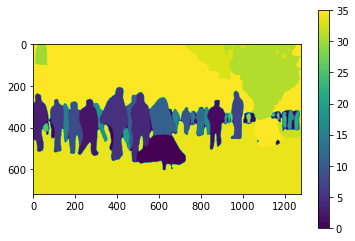

In [206]:
plt.imshow(panoptic_seg[10])
plt.colorbar()

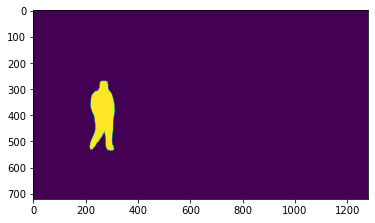

In [229]:
plt.imshow((panoptic_seg[10] == 2)) #[2,4,5,8,11]

## Draw Most Salient Objects based on bottom-up saliency in GazeCom Videos

In [66]:

videos_run =[s for s in range(0,17)]
num_frames = 595
for v in tqdm(videos_run, desc="videos"):#len(video_path_list)
    videoloc = data_path_list[v] #video_path_list[v]
    print(videoloc)
    video_name = os.path.splitext(os.path.basename(videoloc))[0][:-5]

    most_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/'
    mask_path = most_salient_objects_path + video_name + '_lowlevel-salient-objects.npy'
    salient_object_ids = np.load(mask_path,allow_pickle=True)
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    in_file = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK/' + video_name + '.mpg'
    out_file = most_salient_objects_path + video_name + '.avi'

    video_in = cv2.VideoCapture(in_file)
    video_out = cv2.VideoWriter(out_file, fourcc, 30, (1280,720))
    success,img = video_in.read()
    count = 0
    while (success and count < 595):
        #resized = cv2.resize(salient_object_mask[count,:,:], (1280,720), interpolation = cv2.INTER_AREA)
        for i in range(len(salient_object_ids[count])):
            segment_id = salient_object_ids[count][i]
            mask = (panoptic_seg[count].numpy()==segment_id).astype(np.uint8)
            if (np.count_nonzero(mask)!=0):
                contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                cv2.drawContours(img, contours, -1, (255, 0, 0), 3) 
                # compute the center of the contour
                for c in contours:
                    M = cv2.moments(c)
                    if M['m00']!=0:
                    
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])
                        # draw the contour and center of the shape on the image
                        cv2.putText(img, str(i), (cX, cY),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        count += 1
        video_out.write(img)
        success,img = video_in.read()
    video_out.release()
    video_in.release()


/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/beach_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/breite_strasse_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bridge_1_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bridge_2_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bumblebee_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/doves_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/ducks_boat_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/ducks_children_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/golf_data.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panopt

In [172]:
M['m00']

0.0

## Most Salient Objects based on Hierachical Motion Segmentation